<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Causal Inference In Statistics - A Primer</h1>
        <h1>2.4 d-separation</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
    <div style="float: right; margin-right:10px;"> <p><a href="https://amzn.to/3gsFlkO" target=_blank><img src='data/causality.jpeg' width='100px'>
        <!--Amazon Affiliate Link--></a></p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import statsmodels.formula.api as smf
from itertools import combinations

from CausalModel import CausalModel

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.2.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: f7b1abb57541776dc786174deb102ca4ab864df6

matplotlib : 3.10.0
pandas     : 2.2.3
numpy      : 2.2.4
statsmodels: 0.14.4
watermark  : 2.5.0



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Review

In [4]:
fig25 = CausalModel()
fig25.load_model('dags/Primer.Fig.2.5.dot')

In [5]:
fig25.dag.nodes

NodeView(('X', 'R', 'S', 'T', 'U', 'V', 'Y'))

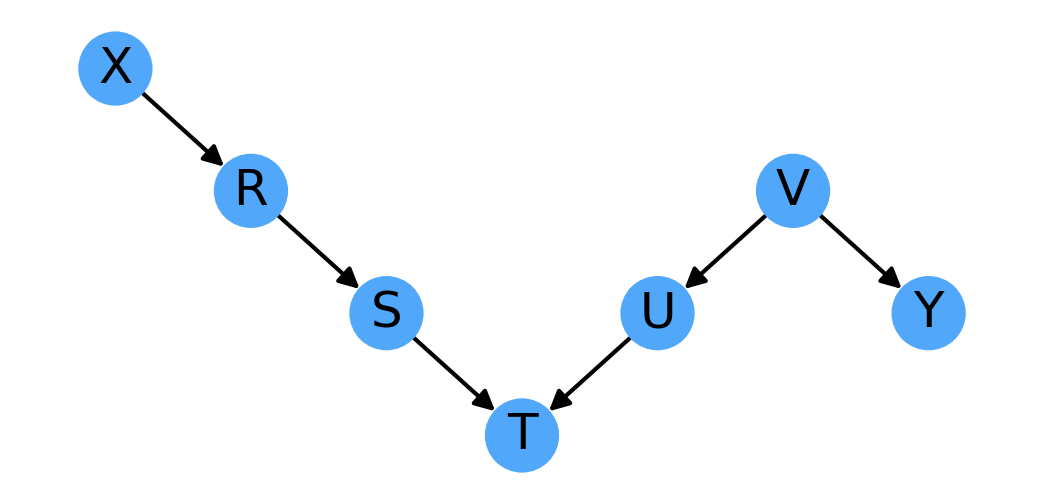

In [6]:
fig, ax = plt.subplots(1, figsize=(4, 2.2))
fig25.pos = {'X': (0, 0), 'R': (1, -1), 'S':(2, -2), 'T':(3, -3), 'U':(4, -2), 'V':(5, -1), 'Y': (6, -2)}
fig25.plot(ax=ax)

In [7]:
nodes = fig25.dag.nodes()

In [8]:
all_pairs = pd.DataFrame(combinations(nodes, 2), columns=['source', 'target'])

In [9]:
all_pairs

,source,target
0,X,R
1,X,S
2,X,T
3,X,U
4,X,V
5,X,Y
6,R,S
7,R,T
8,R,U
9,R,V


In [10]:
all_pairs['candidate'] = True
all_pairs['candidate'] = all_pairs.apply(lambda x: False if len(set(x[:2].values) & {'R', 'V'}) > 0 else x['candidate'], axis=1)

In [11]:
all_pairs = all_pairs[all_pairs['candidate']][['source', 'target']].copy()

In [12]:
all_pairs['Result'] = [
    "Rule 1, Independent",
    "Rule 1, Independent",
    "Blocked, Independent",
    "Blocked, Independent",
    "Rule 0, Dependent",
    "Rule 3, Independent",
    "Blocked, Independent",
    "Rule 0, Dependent",
    "Rule 2, Independent",
    "Rule 2, Independent"
]

### Model Simulation

In [13]:
N = 100000
df = pd.DataFrame({'X': np.random.normal(0, 1, N)})
df['R'] = df['X'] + np.random.normal(0, .1, N)
df['S'] = df['R'] + np.random.normal(0, .1, N)
df['V'] = np.random.normal(0, 1, N)
df['Y'] = df['V'] + np.random.normal(0, .1, N)
df['U'] = df['V'] + np.random.normal(0, .1, N)
df['T'] = np.sqrt(0.5)*df['S'] + np.sqrt(0.5)*df['U'] + np.random.normal(0, .1, N)

In [14]:
remove = set(['R', 'V'])

formula = '%s ~ 1 + %s +' + ' + '.join(remove)

summary = {}

for node_i, node_j in all_pairs[['source', 'target']].values: #combinations(nodes, 2):    
    if len(set([node_i, node_j]) & remove) > 0:
        continue
    
    print(node_i, node_j)
    fml = formula % (node_i, node_j)
    
    results = smf.ols(fml, df).fit()
    summary[(node_i, node_j)] = list(results.conf_int().loc[node_j].values)
    summary[(node_i, node_j)].append(results.params[node_j])
    summary[(node_i, node_j)].append(results.pvalues[node_j])

X S
X T
X U
X Y
S T
S U
S Y
T U
T Y
U Y


### Visualize the coefficients for each pair of variables

In [15]:
summary = pd.DataFrame(summary).T

In [16]:
def plot_coefficients(summary):
    fig, ax = plt.subplots(1)
    ax.axvline(x=0, c='darkgray', linestyle=':', linewidth=2)
    ax.hlines(y=np.arange(summary.shape[0]), xmin=summary[0], xmax=summary[1], lw=2, color=colors[1])
    ax.vlines(ymin=np.arange(summary.shape[0])-.2, ymax=np.arange(summary.shape[0])+.2, x=summary[2], lw=2, color=colors[1])
    ax.set_yticks(np.arange(summary.shape[0]))
    ax.set_yticklabels([r'$r_{%s%s}$' % (node_i, node_j) for node_i, node_j in summary.index])
    ax.set_xlabel('Coeffient estimate')
    ax.set_ylabel('Variable Pair Coefficient')
    ax.grid(linewidth=.5)

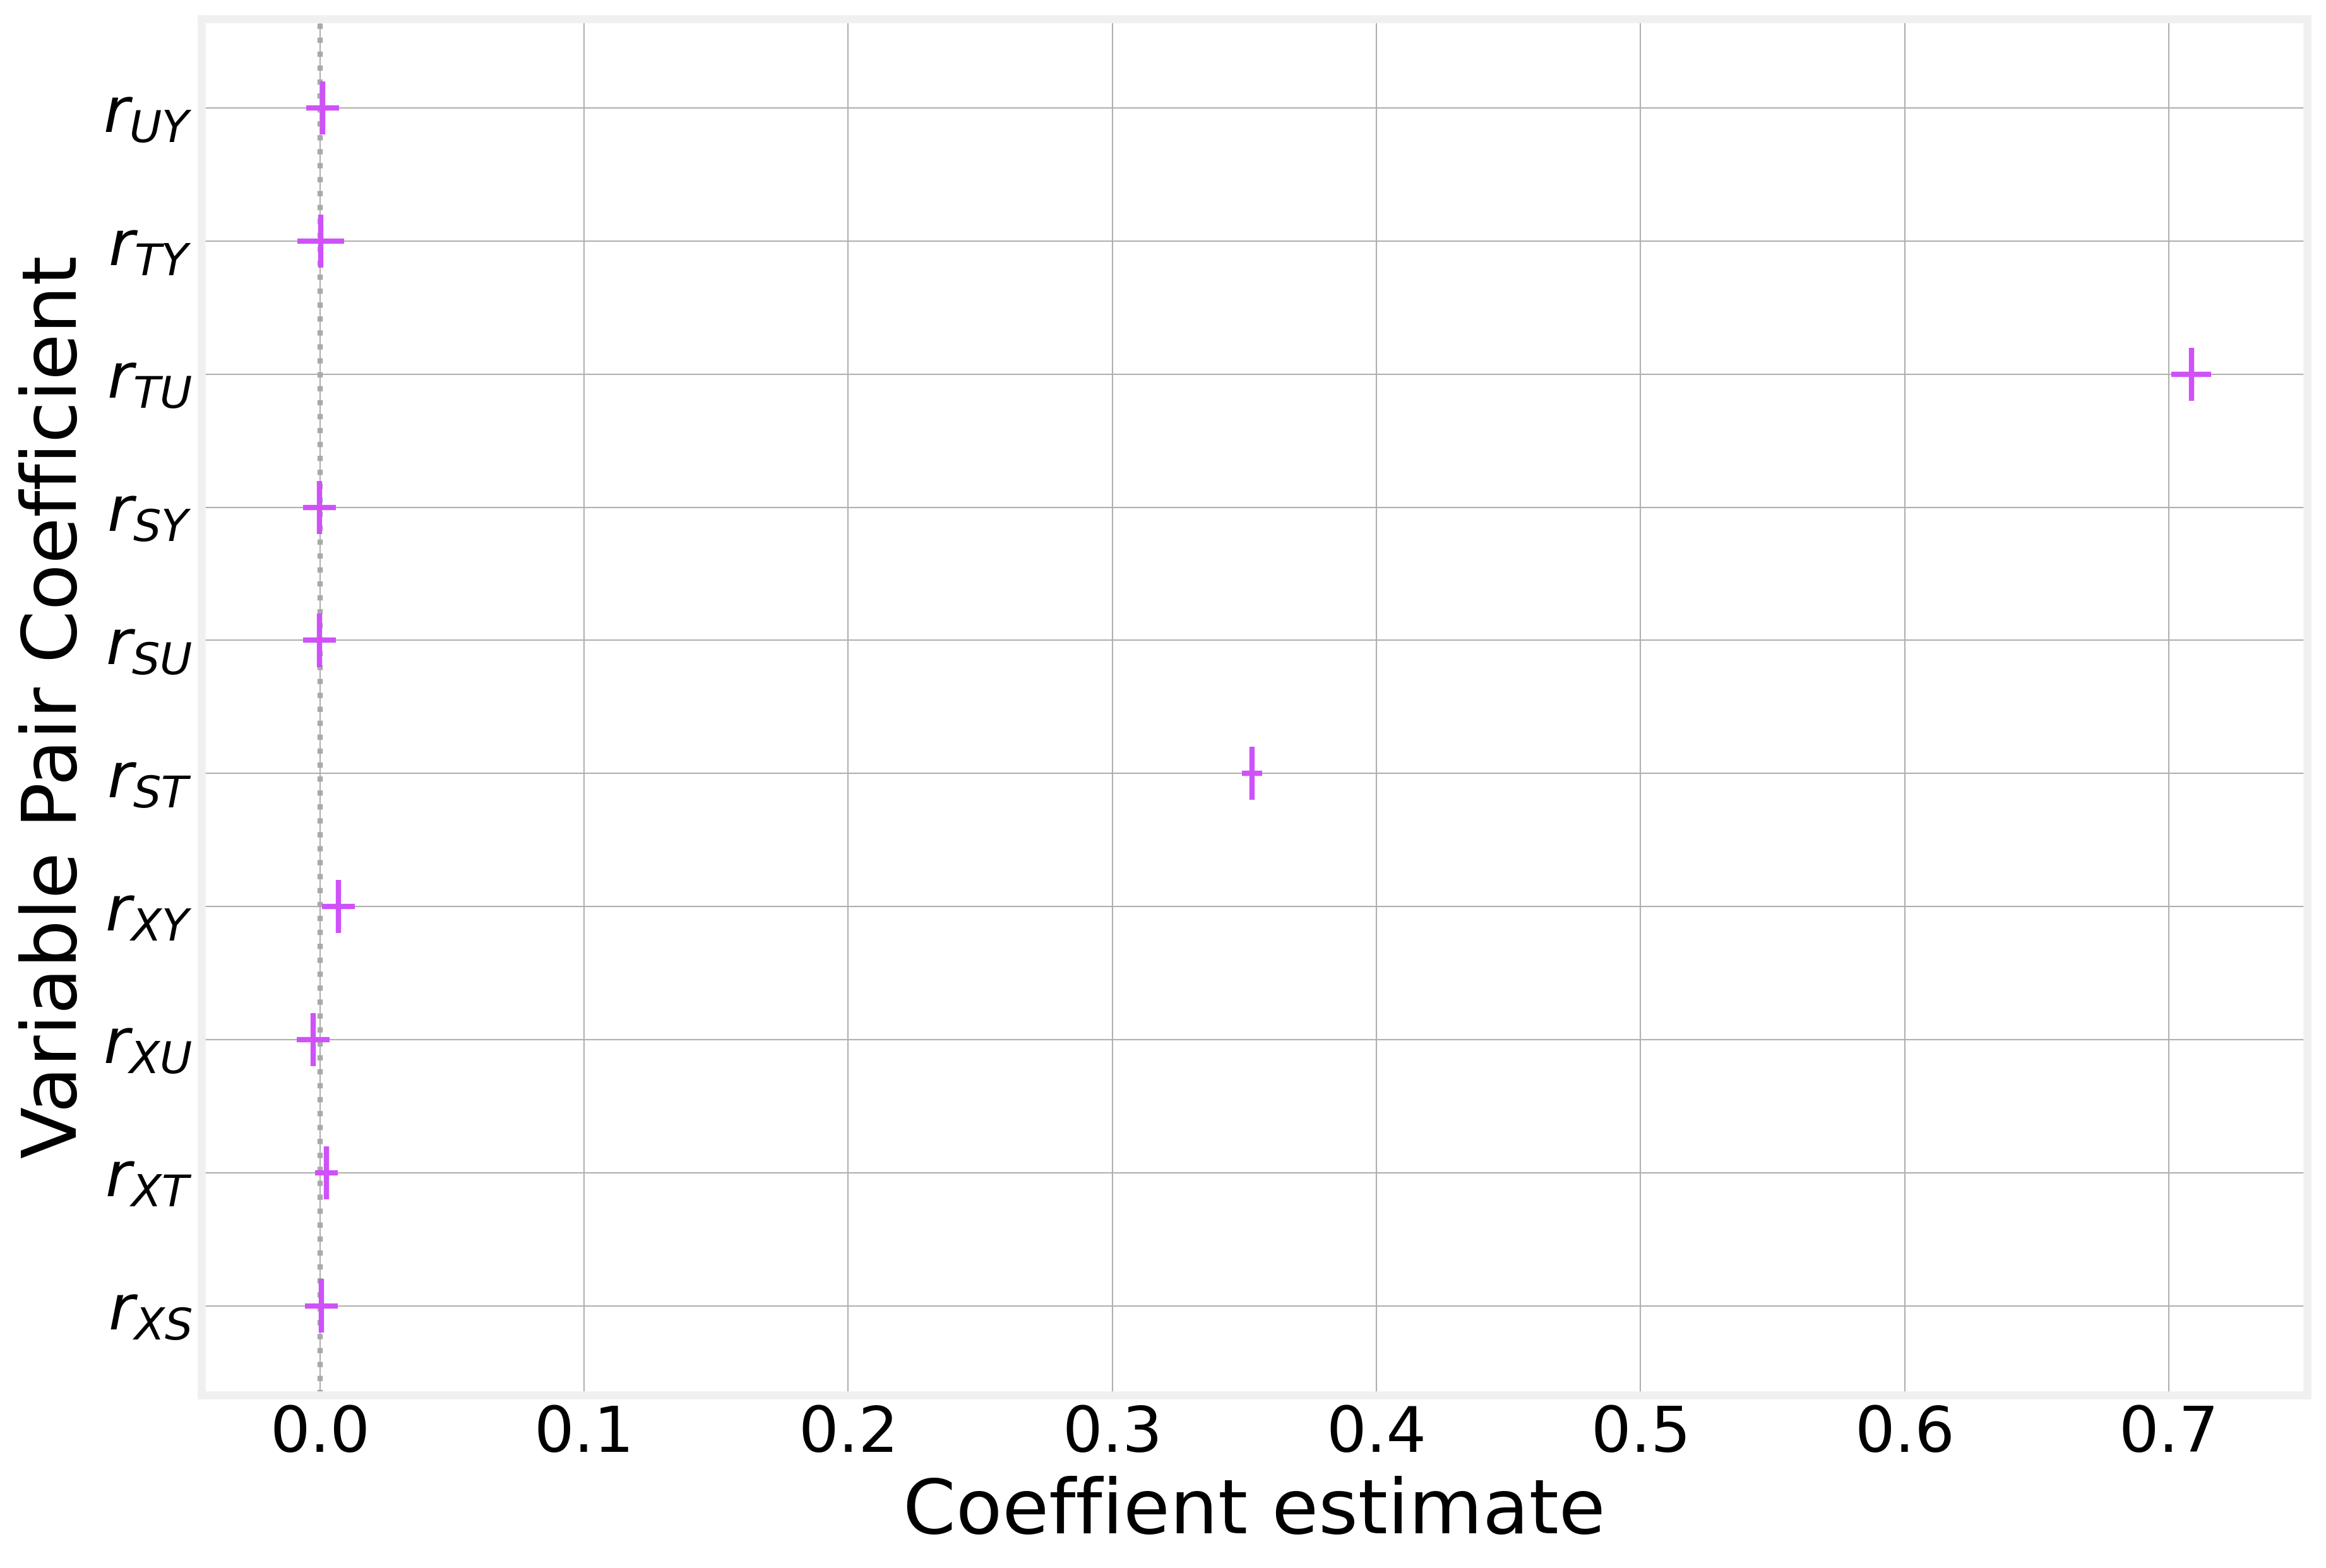

In [17]:
plot_coefficients(summary)

## d-separation

In [18]:
G = CausalModel()
G.add_causation('Uz', 'Z')
G.add_causation('Uw', 'W')
G.add_causation('Ux', 'X')
G.add_causation('Uy', 'Y')
G.add_causation('Uu', 'U')
G.add_causation('Z', 'W')
G.add_causation('X', 'W')
G.add_causation('X', 'Y')
G.add_causation('W', 'U')

G.pos = {'Uz':(-1, 1.5), 'Z':(-1, 1), 'W':(0, 0), 'Uw': (0, 0.5), 
         'X': (1, 1), 'Ux':(1, 1.5), 'Y':(2, 1), 'Uy':(2, 1.5),
         'U': (0, -1), 'Uu':(-0.5, -0.5)}

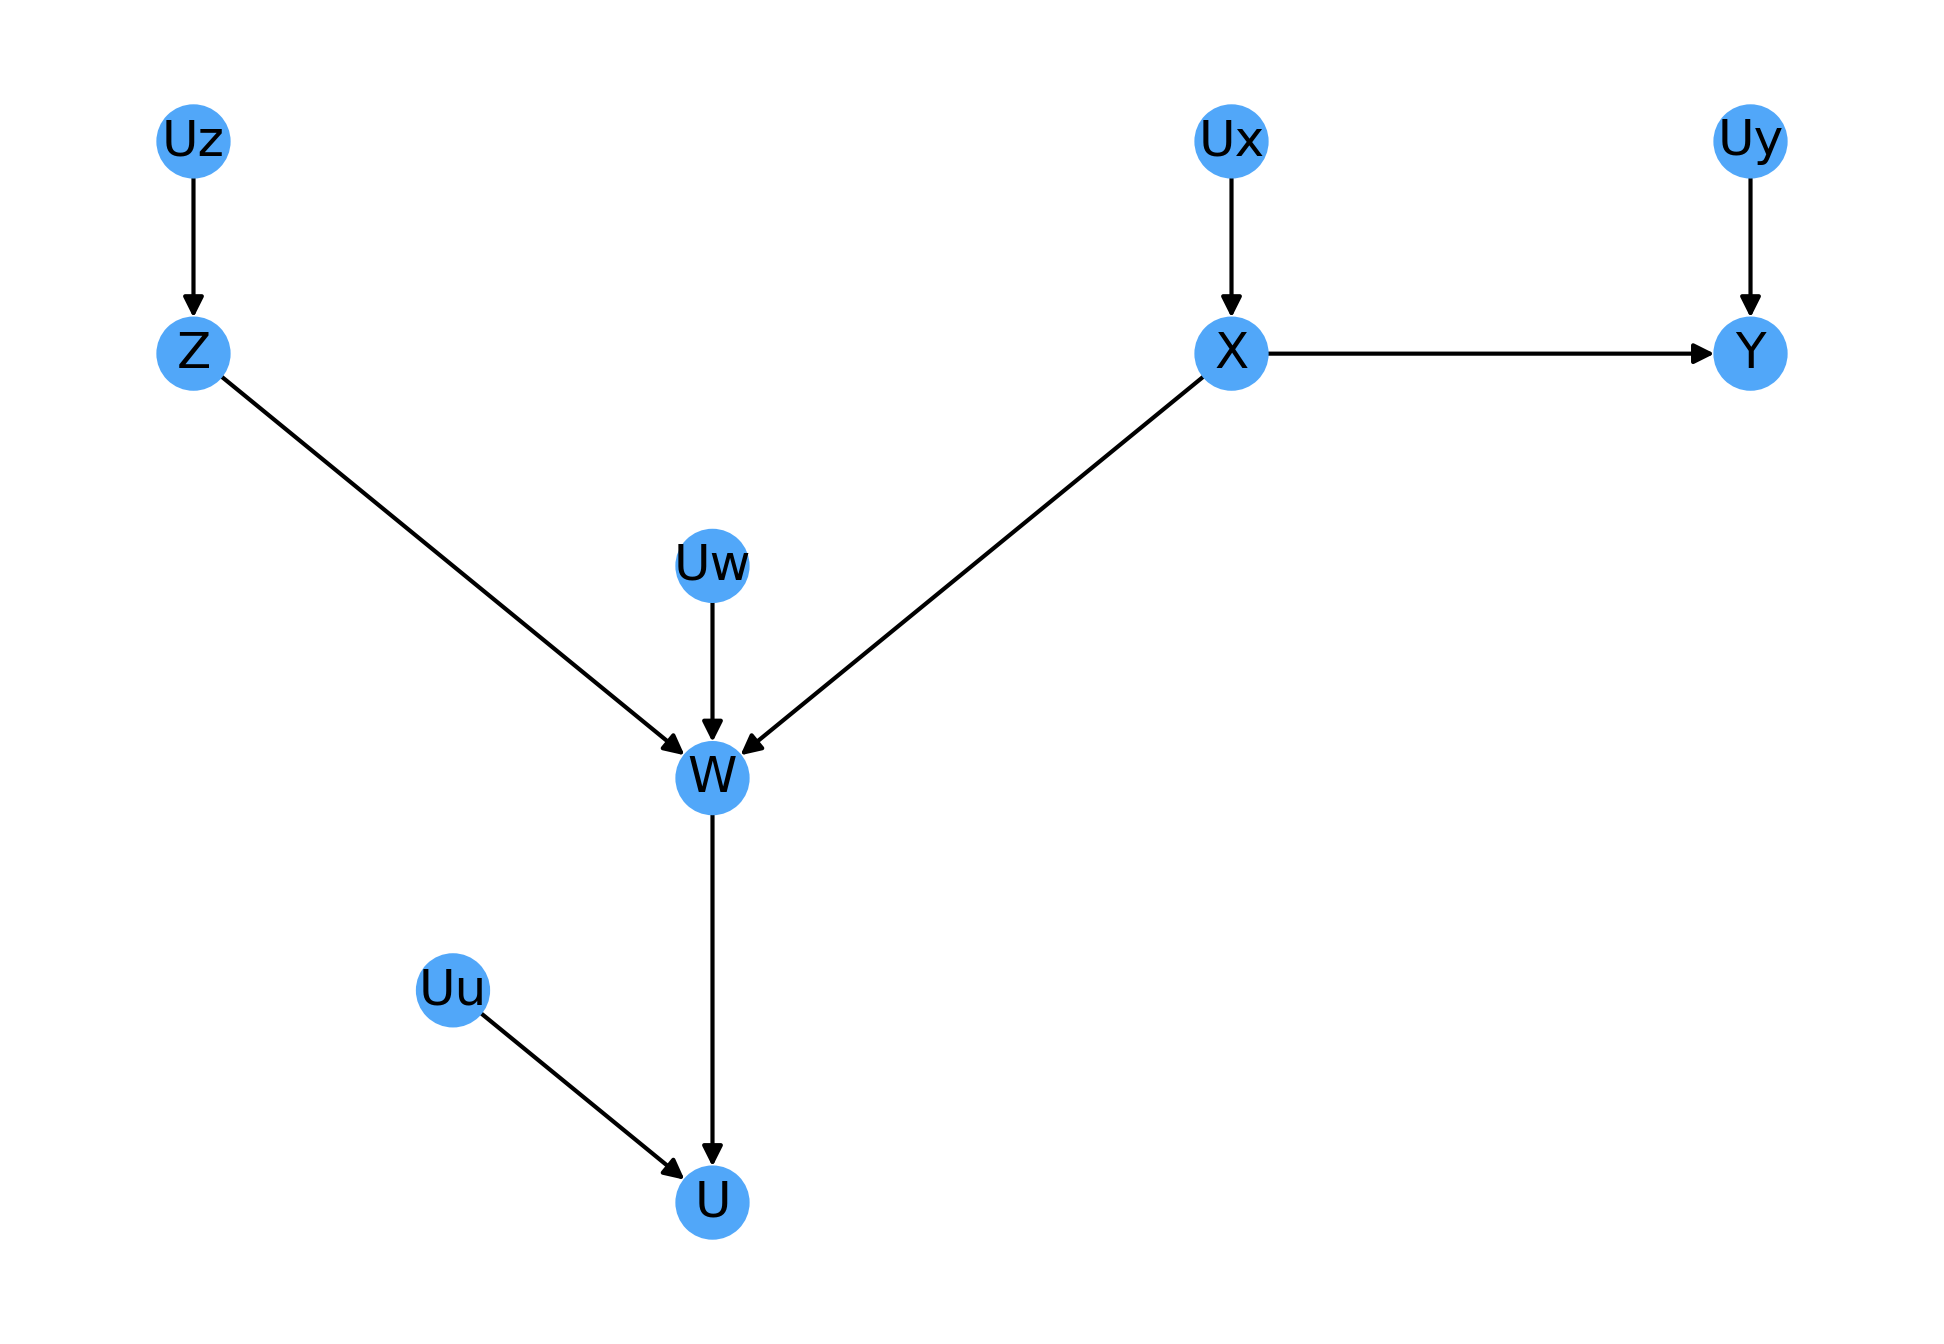

In [19]:
fig, ax = plt.subplots(1, figsize=(7, 5))
G.plot(ax=ax)

In [20]:
G.save_model('dags/Primer.Fig.2.7.dot')

This graph has only one path connecting X and Y

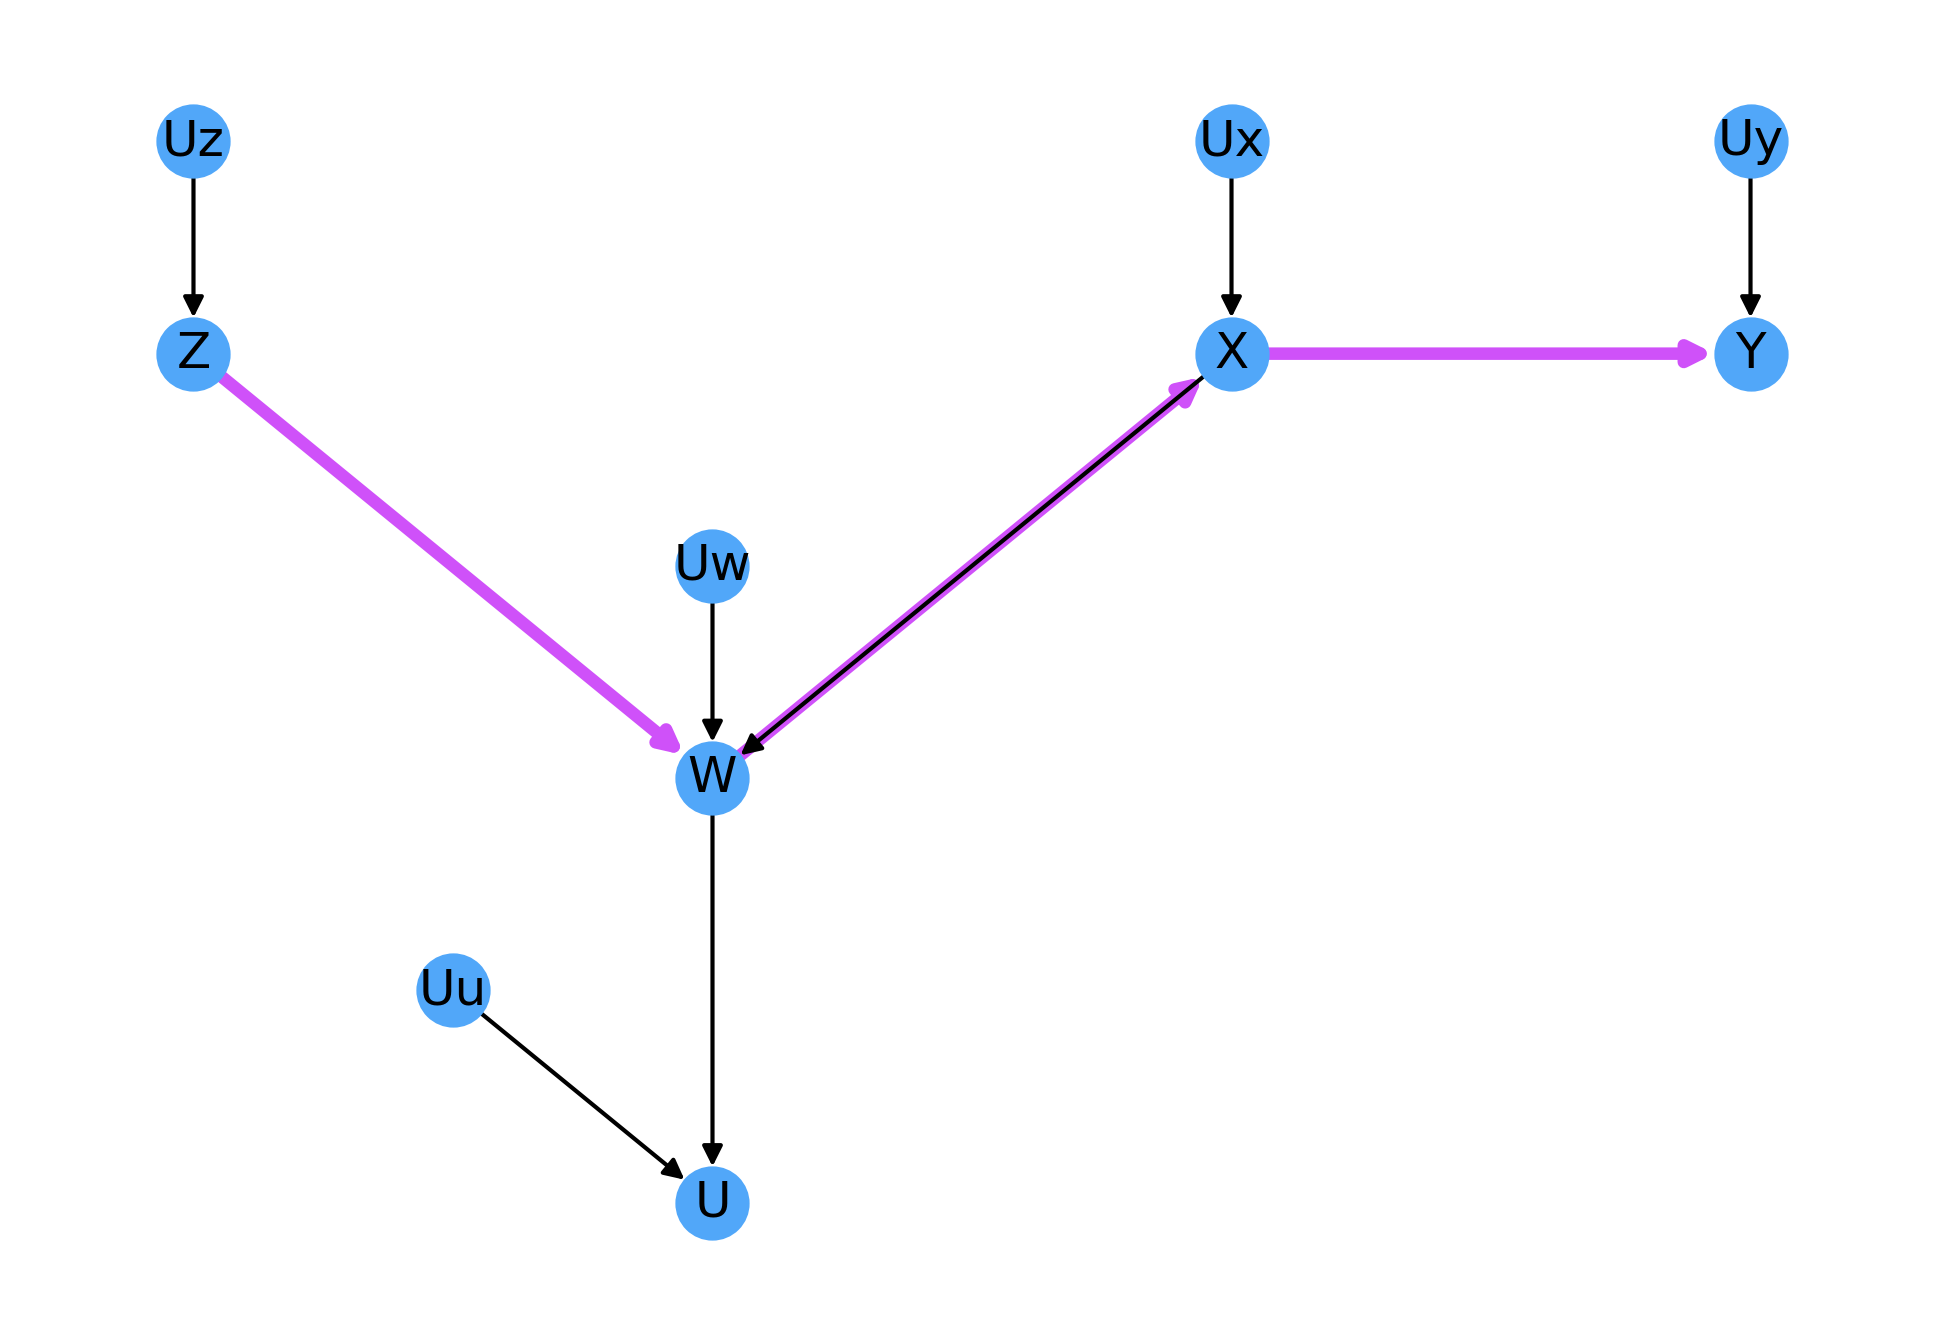

In [21]:
fig, ax_lst = plt.subplots(1, figsize=(7, 5))
ax_lst = np.array(ax_lst).flatten()

for i, path in enumerate(list(G.all_paths('Z', 'Y'))):
    G.plot_path(path, ax=ax_lst[i])

fig.tight_layout()

If we add a second path between X and Y, we obtain:

In [22]:
G = CausalModel()
G.add_causation('Uz', 'Z')
G.add_causation('Uw', 'W')
G.add_causation('Ux', 'X')
G.add_causation('Uy', 'Y')
G.add_causation('Uu', 'U')
G.add_causation('Ut', 'T')
G.add_causation('Z', 'W')
G.add_causation('X', 'W')
G.add_causation('X', 'Y')
G.add_causation('W', 'U')
G.add_causation('T', 'Z')
G.add_causation('T', 'Y')

G.pos = {'Uz':(-1, 1.5), 'Z':(-1, 1), 'W':(0, 0), 'Uw': (0, 0.5), 
         'X': (1, 1), 'Ux':(1, 1.5), 'Y':(2, 1), 'Uy':(2, 1.5),
         'U': (0, -1), 'Uu':(-0.5, -0.5), 'T':(.5, 2), 'Ut':(.5, 2.5)}

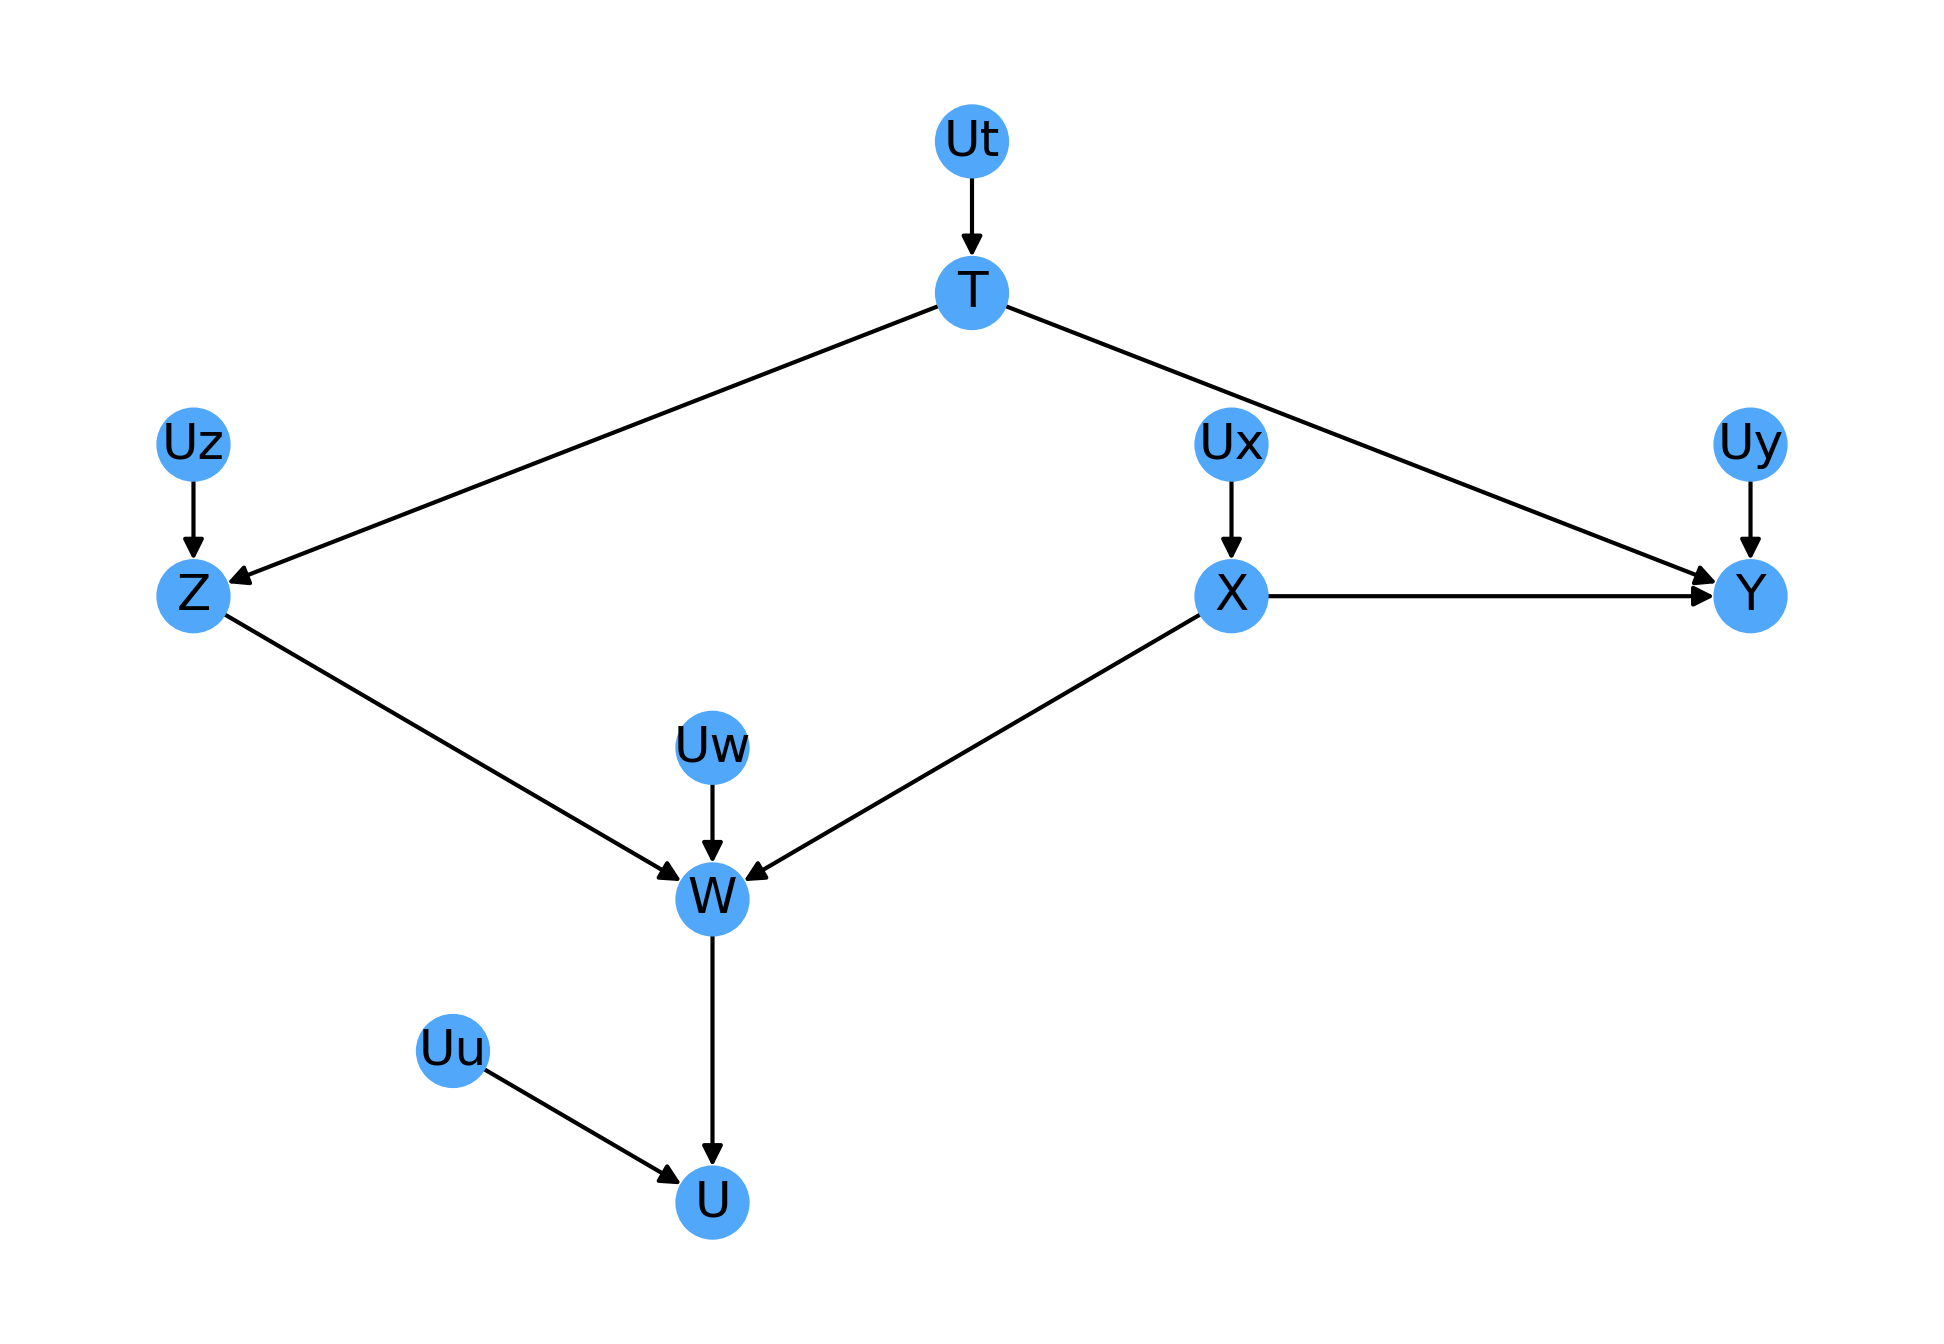

In [23]:
fig, ax = plt.subplots(1, figsize=(7, 5))
G.plot(ax=ax)

In [24]:
G.save_model('dags/Primer.Fig.2.8.dot')

And we can easily visualize both paths

In [25]:
path

('Z', 'W', 'X', 'Y')

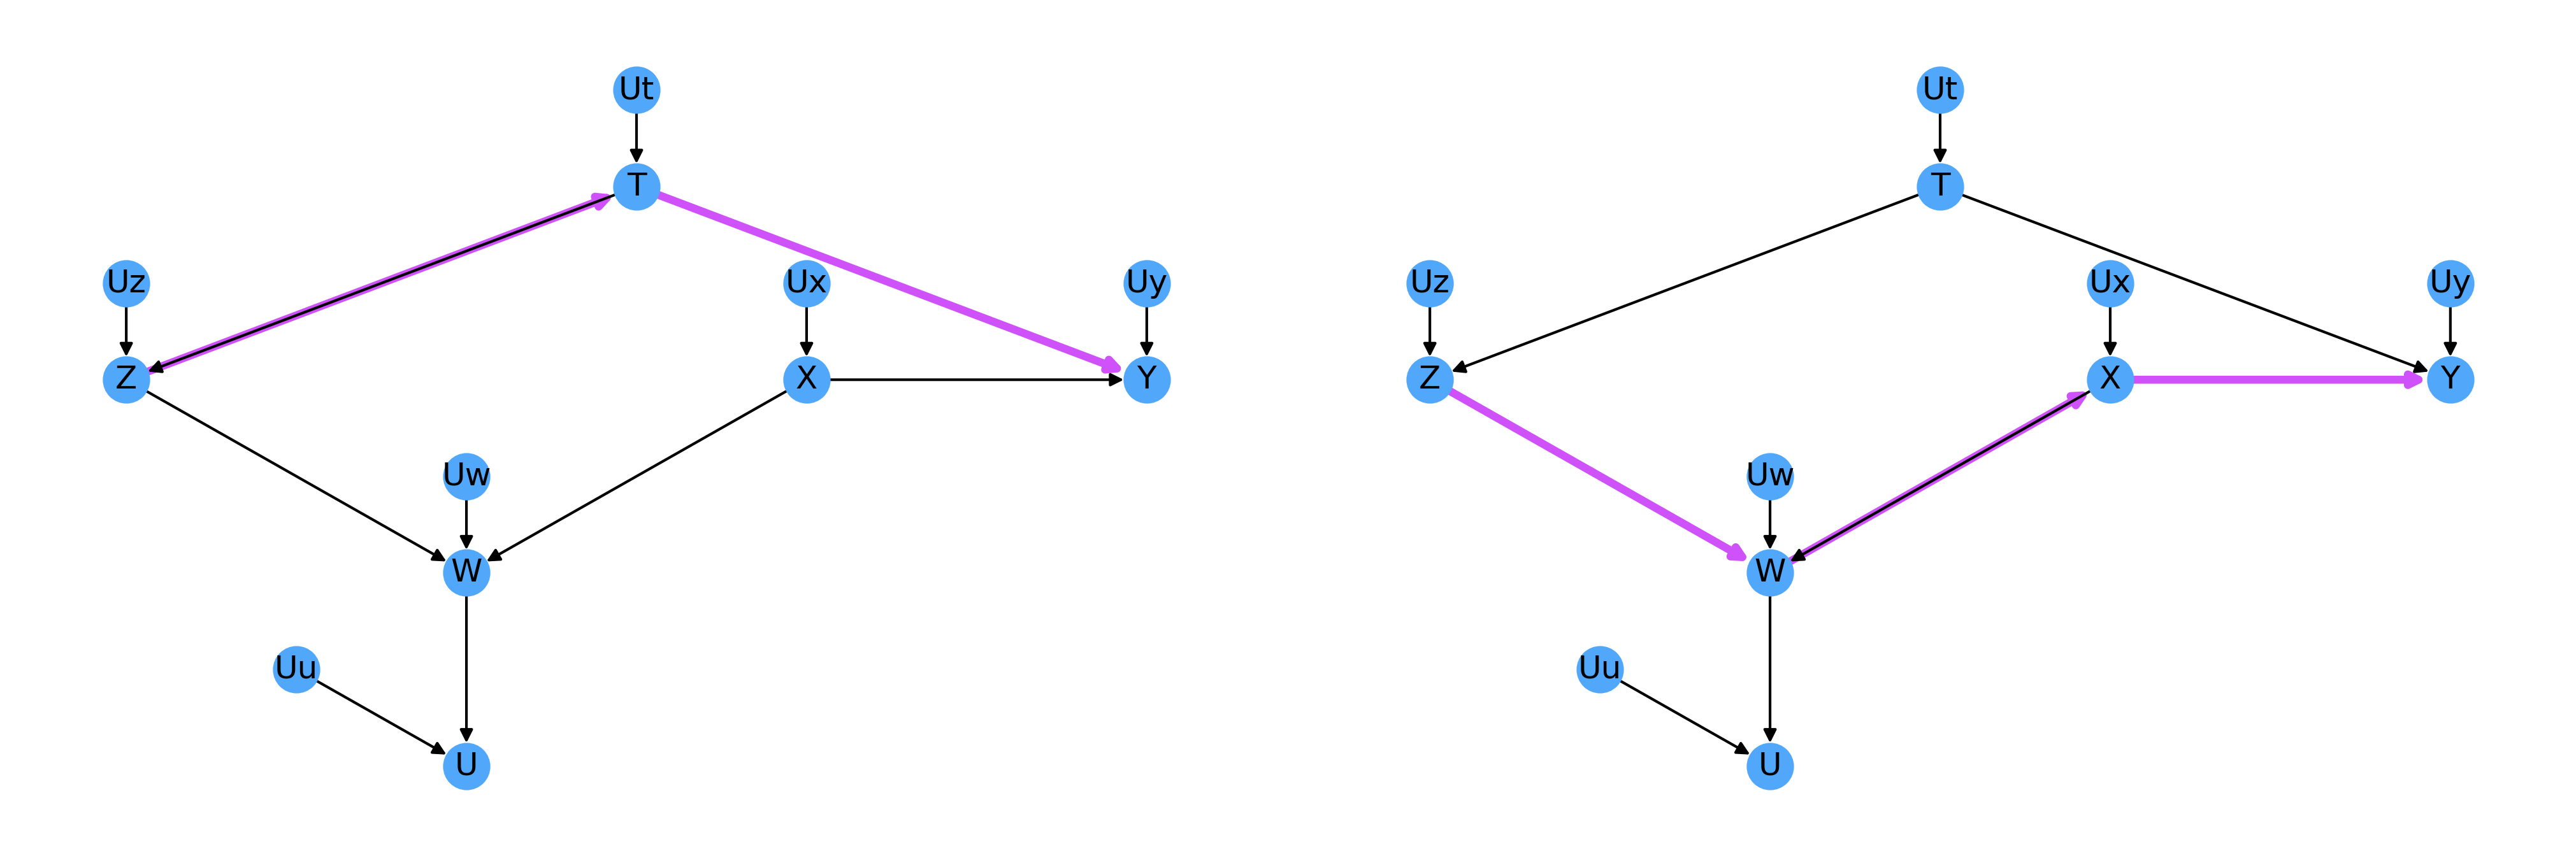

In [26]:
fig, ax_lst = plt.subplots(1, 2, figsize=(14, 5))
ax_lst = np.array(ax_lst).flatten()

for i, path in enumerate(list(G.all_paths('Z', 'Y'))[::-1]):
    G.plot_path(path, ax=ax_lst[i])

fig.tight_layout()

### Study question 2.4.1

In [27]:
G = CausalModel()
G.add_causation('Z1', 'Z3')
G.add_causation('Z1', 'X')
G.add_causation('Z2', 'Z3')
G.add_causation('Z2', 'Y')
G.add_causation('Z3', 'X')
G.add_causation('Z3', 'Y')
G.add_causation('X', 'W')
G.add_causation('W', 'Y')

G.pos = {'Z3':(0, 0), 'Z1':(-1, 1), 'Z2':(1, 1), 'X':(-1, -1), 'W':(0, -1), 'Y':(1, -1)}

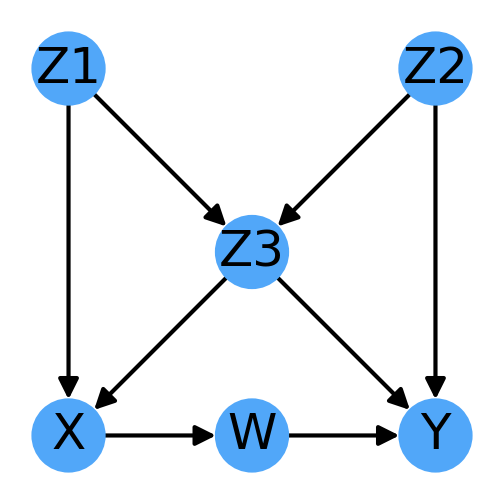

In [28]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
G.plot(ax=ax)

In [29]:
G.save_model('dags/Primer.Fig.2.9.dot')

We have 5 total paths connecting X and Y

In [30]:
G.all_paths('X', 'Y')

{('X', 'W', 'Y'),
 ('X', 'Z1', 'Z3', 'Y'),
 ('X', 'Z1', 'Z3', 'Z2', 'Y'),
 ('X', 'Z3', 'Y'),
 ('X', 'Z3', 'Z2', 'Y')}

That we can visualize side by side

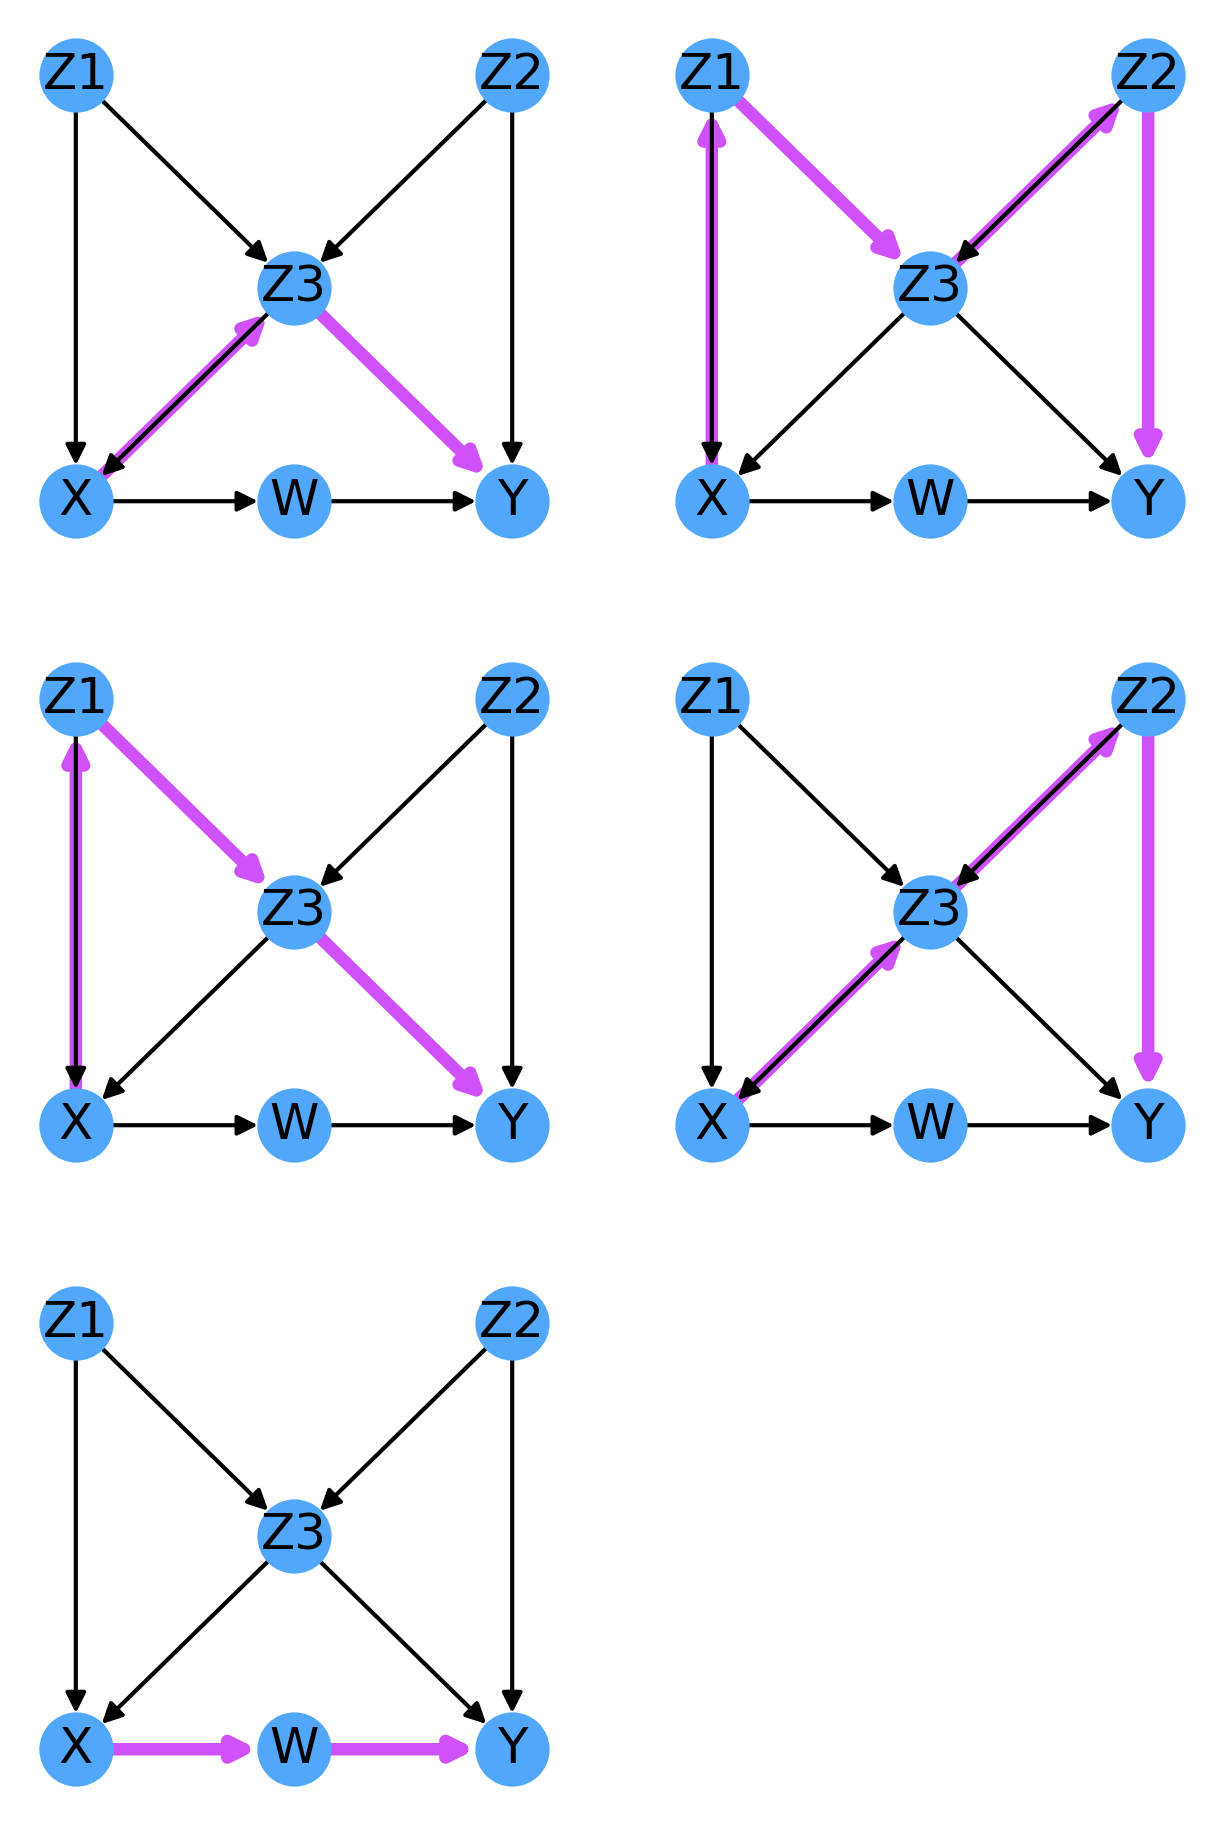

In [31]:
fig, ax_lst = plt.subplots(3, 2, figsize=(4.6, 6.6))
ax_lst = np.array(ax_lst).flatten()

for i, path in enumerate(G.all_paths('X', 'Y')):
    G.plot_path(path, ax=ax_lst[i])

ax_lst[-1].axis('off')
fig.tight_layout()

### Simulate the model

To verify our calculations we simulate the model using Gaussian distributed random numbers

In [32]:
N = 100000
df = pd.DataFrame({'Z1': np.random.normal(0, 1, N), 'Z2': np.random.normal(0, 1, N),})
df['Z3'] = df['Z1'] + df['Z2'] + np.random.normal(0, .1, N)
df['X'] = df['Z1'] + df['Z3'] + np.random.normal(0, .1, N)
df['W'] = df['X'] + np.random.normal(0, .1, N)
df['Y'] = df['W'] + df['Z3'] + df['Z2'] + np.random.normal(0, .1, N)

In [33]:
df

,Z1,Z2,Z3,X,W,Y
0,-1.058168,-0.970246,-1.866951,-2.947249,-2.931477,-5.713435
1,-1.039789,-0.518324,-1.603917,-2.683878,-2.656703,-4.738233
2,-0.974982,0.783103,-0.312295,-1.523198,-1.550183,-0.968064
3,-0.572810,-1.046626,-1.587019,-2.268438,-2.384686,-4.993943
4,0.603671,-2.142493,-1.572174,-0.970873,-0.932704,-4.695940
...,...,...,...,...,...,...
99995,0.073397,1.238280,1.565253,1.697695,1.691013,4.469200
99996,0.913862,2.116528,2.995688,3.954962,4.061142,9.201833
99997,-0.409440,-1.100588,-1.694418,-2.035549,-2.129797,-4.726587
99998,0.239409,1.490656,1.646655,1.877727,1.590475,4.718105


And thest the conditional independence of X and Y

In [34]:
formula = 'X ~ 1 + Y + W + Z1 + Z3'

In [35]:
results = smf.ols(formula, df).fit()

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.495e+07
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:52:31   Log-Likelihood:             1.2289e+05
No. Observations:              100000   AIC:                        -2.458e+05
Df Residuals:                   99995   BIC:                        -2.457e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.863e-05      0.000      0.262      0.793      -0.000       0.000
Y              0.0030      0.002      1.922      0.055   -6.08e-05       0.006
W              0.4962      0.002    221.430      0.000       0.492       0.501
Z1             0.5039      0.002    223.741      0.000       0.499       0.508
Z3             0.4946      0.004    139.757      0.000       0.488       0.502
==============================================================================
Omnibus:                        1.644   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                1.648
Skew:                          -0.010   Prob(JB):                        0.439
Kurtosis:                       2.997   Cond. No.                         93.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>